Test on piecewise linear curves in $SO(3)^n$

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os
import torch
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
from itertools import chain

set_matplotlib_formats('pdf', 'svg')

from deepthermal.FFNN_model import fit_FFNN, FFNN
from deepthermal.validation import create_subdictionary_iterator, k_fold_cv_grid, add_dictionary_iterators
from deepthermal.plotting import plot_result, plot_model_1d

from neural_reparam.reparametrization import (
    get_elastic_metric_loss,
    compute_loss_reparam,
)
from neural_reparam.interpolation import get_pl_curve_from_data
from neural_reparam.ResNet import ResNet


In [63]:
import sys

sys.path.append("../../")
from animation.animation_manager import fetch_animations, unpack
from so3.curves import move_origin_to_zero, dynamic_distance
from so3.helpers import crop_curve
from so3.dynamic_distance import find_optimal_diffeomorphism, create_shared_parameterization
from so3.clustering.id_set import crop_curve_based_on_id, get_id_set
from so3.transformations import skew_to_vector, SRVT
from so3 import animation_to_SO3

max_frame_count = 180

id_set = get_id_set()
print("Load data")

data = [fetch_animations(1, file_name="39_02.amc"),  #walk 6.5 steps
        fetch_animations(1, file_name="35_26.amc"),  # run/jog 3 steps
        fetch_animations(1, file_name="16_35.amc")  # run/jog 3 steps
        ]

# walk
subject, animation, desc0 = unpack(data[2])
curve_full = animation_to_SO3(subject, animation)
curve = crop_curve(curve_full, stop=240)  #first 2 seconds
c_0 = move_origin_to_zero(curve)
print(desc0)

# run
subject, animation, desc1 = unpack(data[1])
curve_full = animation_to_SO3(subject, animation)
curve = crop_curve(curve_full, stop=240)  #first 2 seconds
c_1 = move_origin_to_zero(curve)
print(desc1)
print(c_0.shape)
print(c_1.shape)

Load data
run/jog
run/jog
(23, 161, 3, 3)
(23, 137, 3, 3)


In [64]:
#calculate distances
I0 = np.linspace(0, 1, c_0.shape[1])
I1 = np.linspace(0, 1, c_1.shape[1])
q_data_ = skew_to_vector(SRVT(c_0, I0))
r_data_ = skew_to_vector(SRVT(c_1, I1))
I, q_data, r_data = create_shared_parameterization(q0=q_data_, q1=r_data_, I0=I0, I1=I1)
shared_frames = I.shape[0]
q_func = get_pl_curve_from_data(data=q_data)
r_func = get_pl_curve_from_data(data=r_data)


In [65]:
d_01 = dynamic_distance(c_0, c_1, depth=10)
print(d_01)

KeyboardInterrupt: 

In [ ]:
I1_new = find_optimal_diffeomorphism(q0=q_data, q1=r_data, I0=I, I1=I, depth=10)


In [66]:
########
DIR = "../figures/curve_so3/"
SET_NAME = "pl_eks_7"
PATH_FIGURES = os.path.join(DIR, SET_NAME)
if not os.path.exists(PATH_FIGURES):
    os.makedirs(PATH_FIGURES)
########

FOLDS = 1
N = shared_frames  # training points internal
lr_scheduler = lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=5,
                                                                        verbose=True)
loss_func = get_elastic_metric_loss(r=r_func, constrain_cost=1e4, verbose=False)
penalty_free_loss_func = get_elastic_metric_loss(r=r_func, constrain_cost=0, verbose=False)

MODEL_PARAMS = {
    "input_dimension": [1],
    "output_dimension": [1],
    "n_hidden_layers": [2],  #,8,16,64],
    "model": [ResNet],
    "neurons": [2, 4, 8, 16, 32, 64, 128]
}
MODEL_PARAMS_2 = {
    "input_dimension": [1],
    "output_dimension": [1],
    "model": [ResNet],
    "n_hidden_layers": [1, 2, 4, 8, 16, 32],
    "neurons": [8],
}

# extend the previous dict with the zip of this
MODEL_PARAMS_EXPERIMENT = {
    "activation": ["relu", "tanh"],
}
TRAINING_PARAMS = {
    "batch_size": [N // 2],
    "regularization_param": [0],
    "compute_loss": [compute_loss_reparam],
    "loss_func": [loss_func],
}
# extend the previous dict with the zip of this
TRAINING_PARAMS_EXPERIMENT = {
    "optimizer": ["strong_wolfe"],
    "num_epochs": [100],
    "learning_rate": [1],
    "stop_stochastic": [90],
    "lr_scheduler": [lr_scheduler]
}


In [67]:
x_train = torch.linspace(0, 1, N, requires_grad=True).unsqueeze(1)
q_train = torch.tensor(q_data)
data = TensorDataset(x_train, q_train)



In [68]:
# create iterators
model_params_iter_1 = create_subdictionary_iterator(MODEL_PARAMS)
model_params_iter_2 = create_subdictionary_iterator(MODEL_PARAMS_2)
model_params_iter = chain.from_iterable((model_params_iter_1, model_params_iter_2))

model_exp_iter = create_subdictionary_iterator(MODEL_PARAMS_EXPERIMENT, product=False)
exp_model_params_iter = add_dictionary_iterators(model_exp_iter, model_params_iter)

training_params_iter = create_subdictionary_iterator(TRAINING_PARAMS)
training_exp_iter = create_subdictionary_iterator(TRAINING_PARAMS_EXPERIMENT, product=False)
exp_training_params_iter = add_dictionary_iterators(training_exp_iter, training_params_iter)

Do the actual training

In [69]:
cv_results = k_fold_cv_grid(
    model_params=exp_model_params_iter,
    fit=fit_FFNN,
    training_params=exp_training_params_iter,
    data=data,
    folds=FOLDS,
    verbose=True,
    trials=10
)


Running model (trial=0, mod=0, k=0):
Parameters: ({'input_dimension': 1, 'output_dimension': 1, 'n_hidden_layers': 2, 'model': <class 'neural_reparam.ResNet.ResNet'>, 'neurons': 2, 'activation': 'relu'}, {'batch_size': 144, 'regularization_param': 0, 'compute_loss': <function compute_loss_reparam at 0x123f2d5e0>, 'loss_func': <function get_elastic_metric_loss.<locals>.elastic_metric_loss at 0x1248bee50>, 'optimizer': 'strong_wolfe', 'num_epochs': 100, 'learning_rate': 1, 'stop_stochastic': 90, 'lr_scheduler': <function <lambda> at 0x1248be9d0>})
################################  0  ################################
Training Loss:  nan
Final training Loss:  nan

Running model (trial=0, mod=1, k=0):
Parameters: ({'input_dimension': 1, 'output_dimension': 1, 'n_hidden_layers': 2, 'model': <class 'neural_reparam.ResNet.ResNet'>, 'neurons': 4, 'activation': 'relu'}, {'batch_size': 144, 'regularization_param': 0, 'compute_loss': <function compute_loss_reparam at 0x123f2d5e0>, 'loss_func': <f

In [70]:
# plotting
disc_points = x_train.detach()

plot_kwargs = {
    "x_test": disc_points,
    "x_train": disc_points,
    "y_train": I1_new,
    "x_axis": "t",
    "y_axis": "$\\varphi(t)$",
    "compare_label": "DP solution"
}
plot_result(
    path_figures=PATH_FIGURES,
    **cv_results,
    plot_function=plot_model_1d,
    function_kwargs=plot_kwargs,
)

In [71]:
models = cv_results["models"]

parameters = np.vectorize(lambda model: sum(p.numel() for p in model.parameters()))(models).flatten()
model_type = np.vectorize(str)(models).flatten()
layers = np.vectorize(lambda model: model.n_hidden_layers)(models).flatten()
activation = np.vectorize(lambda model: model.activation)(models).flatten()
neurons = np.vectorize(lambda model: model.neurons)(models).flatten()
loss_array = np.vectorize(lambda model: penalty_free_loss_func(model, x_train, q_train).detach())(models).flatten()
loss_array -= d_01 ** 2
# make data frame
# optims = ["line search", "ADAM", "LBFGS"]*(len(loss_array)//3)
d_results = pd.DataFrame(
    {"loss": loss_array, "neurons": neurons, "layers": layers, "parameters": parameters, "model": model_type,
     "activation": activation})

d_results_layer = d_results[d_results.neurons == 8]
d_results_neurons = d_results[d_results.layers == 2]


/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


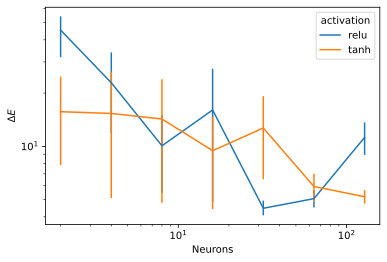

In [72]:
fig_neurons = sns.lineplot(data=d_results_neurons, y="loss", x="neurons", hue="activation", ci=80, err_style="bars")
fig_neurons.set(xscale="log", yscale="log", xlabel="Neurons")
fig_neurons.set(ylabel="$\\Delta E$")
plt.savefig(f"{PATH_FIGURES}/neurons_error.pdf")
plt.show()

In [73]:
print("faled, total:")
print(len(d_results_neurons[d_results_neurons.loss > 10]), len(d_results_neurons))

faled, total:
32 160


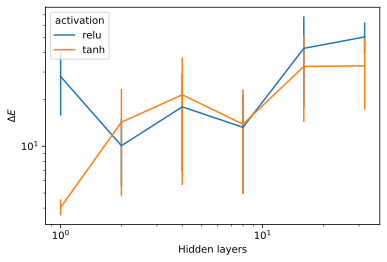

In [74]:
fig_layers = sns.lineplot(data=d_results_layer, y="loss", x="layers", hue="activation", ci=80, err_style="bars")
fig_layers.set(yscale="log", xscale="log", xlabel="Hidden layers", ylabel="Error")
fig_layers.set(ylabel="$\\Delta E$")
plt.savefig(f"{PATH_FIGURES}/layer_error.pdf")
plt.show()

In [75]:
print("faled, total:")
print(len(d_results_layer[d_results_layer.loss
                          > 10]), len(d_results_layer))

faled, total:
35 140


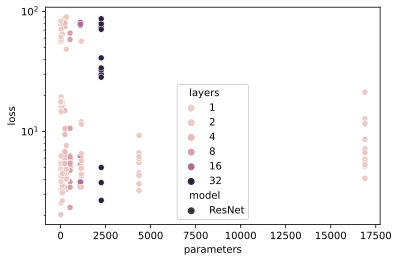

In [76]:
fig_scatter = sns.scatterplot(data=d_results, y="loss", x="parameters", hue="layers", style="model")
fig_neurons.set(ylabel="$E$")
fig_scatter.set(yscale="log")
plt.show()

In [77]:
d_results.to_csv(f"{PATH_FIGURES}/d_results.csv")